In [1]:
!git clone https://github.com/phamdinhkhanh/vnquant
%cd vnquant
!python setup.py install

fatal: destination path 'vnquant' already exists and is not an empty directory.
/content/vnquant
running install
running bdist_egg
running egg_info
writing vnquant.egg-info/PKG-INFO
writing dependency_links to vnquant.egg-info/dependency_links.txt
writing requirements to vnquant.egg-info/requires.txt
writing top-level names to vnquant.egg-info/top_level.txt
writing manifest file 'vnquant.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/vnquant
creating build/bdist.linux-x86_64/egg/vnquant/utils
copying build/lib/vnquant/utils/utils.py -> build/bdist.linux-x86_64/egg/vnquant/utils
copying build/lib/vnquant/utils/__init__.py -> build/bdist.linux-x86_64/egg/vnquant/utils
copying build/lib/vnquant/__version__.py -> build/bdist.linux-x86_64/egg/vnquant
copying build/lib/vnquant/utils.py -> build/bdist.linux-x86_64/egg/vnquant
creating build/bdist.linu

In [2]:
import vnquant.data as web
loader = web.DataLoader('FPT', '2019-01-01','2022-04-22')
data= loader.download()
data.head()

Attributes,high,low,open,close,adjust,volume
Symbols,FPT,FPT,FPT,FPT,FPT,FPT
date,,,,,,
2019-01-02,42.15,41.15,41.20,41.2,20.92,539120
2019-01-03,41.45,40.70,41.45,40.8,20.72,796600
2019-01-04,41.45,40.50,40.60,41.1,20.87,378570
2019-01-07,42.10,41.60,41.80,41.8,21.23,408470
2019-01-08,42.00,41.70,41.80,42.0,21.33,295660


In [3]:
data.shape

(824, 6)

# Kiểm tra chuỗi dừng thông qua visualize

In [4]:
from vnquant import plot
plot.vnquant_candle_stick(data = data,
                      title='FPT Price from 2019-01-01 to 2022-04-22',
                      ylab='Date', xlab='Price',)

# Biến đổi chuỗi thành dừng

In [5]:
import numpy as np
# Tính chuỗi return
r_t = np.log(data['close']/data['close'].shift(1)).values[:, 0]


In [6]:
mean = np.nanmean(r_t)
r_t[0]=mean
r_t[:5]

array([ 0.00120534, -0.00975617,  0.00732604,  0.01688822,  0.00477328])

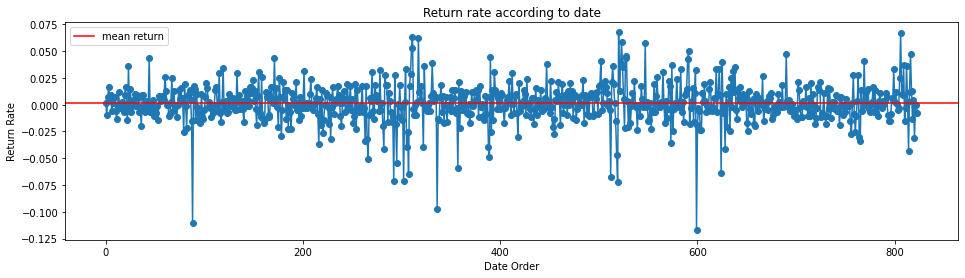

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.plot(np.arange(r_t.shape[0]), r_t, '-o')
plt.axhline(y=mean, label='mean return', c='red')
plt.title('Return rate according to date')
plt.xlabel('Date Order')
plt.ylabel('Return Rate')
plt.legend()
plt.show()

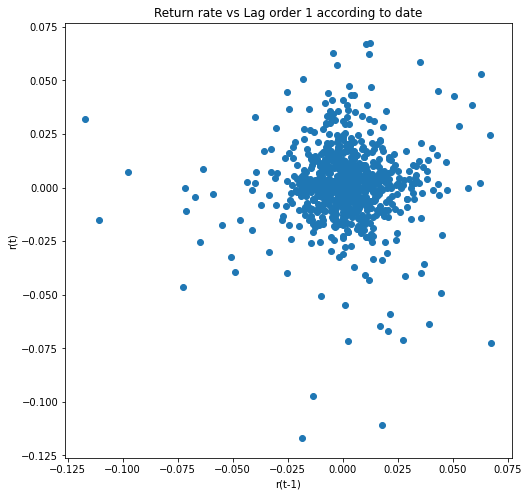

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(x=r_t[1:], y=r_t[:-1])
plt.title('Return rate vs Lag order 1 according to date')
plt.xlabel('r(t-1)')
plt.ylabel('r(t)')
plt.show()

Đồ thị cho thấy 2 chuỗi có mối quan hệ tương quan và thấy rõ chúng là 1 trend tăng.

Text(0, 0.5, 'frequency')

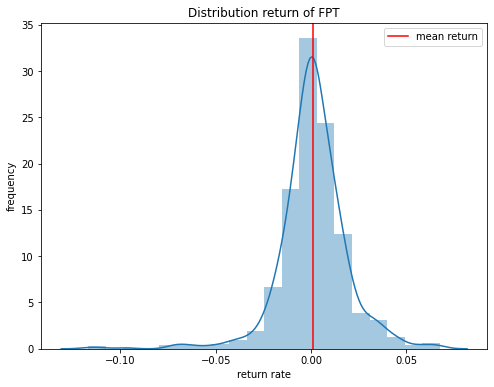

In [9]:
import seaborn as sns

plt.figure(figsize = (8, 6))
sns.distplot(r_t, bins = 20)
plt.axvline(x=mean, label='mean return', c='red')
plt.title('Distribution return of FPT')
plt.legend()
plt.xlabel('return rate')
plt.ylabel('frequency')

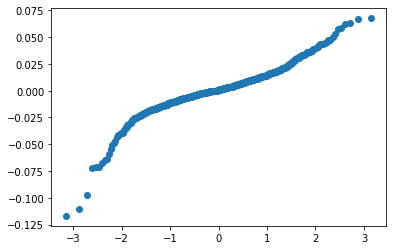

In [10]:
from scipy import stats
tq = stats.probplot(r_t)
plt.scatter(x=tq[0][0], y = tq[0][1])
plt.show()

Check stationary

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(r_t)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


ADF Statistic: -10.228458
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


Build ARIMA model

<Figure size 576x432 with 0 Axes>

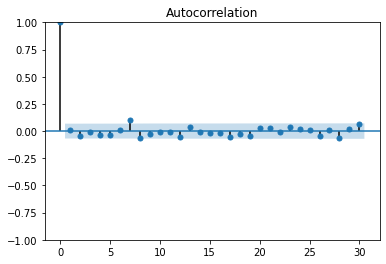

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(r_t)

<Figure size 576x432 with 0 Axes>

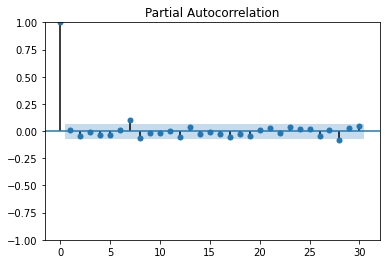

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(r_t)

Manual ARIMA

In [28]:
from statsmodels.tsa.arima.model import ARIMA

def _arima_fit(orders, data):
  models = dict()
  for order in orders:
    model = ARIMA(data, order = order).fit()
    model_name = 'ARIMA({},{},{})'.format(order[0], order[1], order[2])
    print('{} --> AIC={}; BIC={}'.format(model_name, model.aic, model.bic))
    models[model_name] = model
  return models

orders = [(2, 0, 2), (2, 0, 0), (5, 0, 0), (0, 0, 5), (0, 0, 7)]
models = _arima_fit(orders, r_t)

ARIMA(2,0,2) --> AIC=-4263.224249564405; BIC=-4234.939226384949
ARIMA(2,0,0) --> AIC=-4266.64092885766; BIC=-4247.7842467380215
ARIMA(5,0,0) --> AIC=-4263.2059370073275; BIC=-4230.206743297961
ARIMA(0,0,5) --> AIC=-4262.9078929826055; BIC=-4229.908699273239
ARIMA(0,0,7) --> AIC=-4267.728394836522; BIC=-4225.3008600673365


=> Mô hình ARIMA (2,0,2) là tốt nhất vì AIC nhỏ nhất

In [30]:
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(r_t, order = (0, 0, 7))
model_fit = model_arima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  824
Model:                 ARIMA(0, 0, 7)   Log Likelihood                2142.864
Date:                Fri, 23 Sep 2022   AIC                          -4267.728
Time:                        15:55:04   BIC                          -4225.301
Sample:                             0   HQIC                         -4251.452
                                - 824                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.805      0.071      -0.000       0.003
ma.L1          0.0131      0.028      0.471      0.638      -0.041       0.068
ma.L2         -0.0431      0.032     -1.367      0.1

In [31]:
model_fit.forecast(steps=30)[0]

0.0037639468013910783

In [ ]:
data.reset_index(level='date',inplace=True)

In [ ]:
data.shape

(824, 7)

In [ ]:
data.columns= ['Date','High','Low','Open','Closed','Adjust','Volume']

In [ ]:
data = data[['Date','Closed']]

In [ ]:
data.head(5)

,Date,Closed
0,2019-01-02,41.2
1,2019-01-03,40.8
2,2019-01-04,41.1
3,2019-01-07,41.8
4,2019-01-08,42.0


In [ ]:
import datetime 

In [ ]:
(data['Date'][2]-data['Date'][1]).days

1

In [ ]:
(data['Date'][2]-data['Date'][3]).days

-3

In [ ]:
data['Date'][0]

Timestamp('2019-01-02 00:00:00')

In [ ]:
data['Date'][0] + datetime.timedelta(days=1)

Timestamp('2019-01-03 00:00:00')

In [ ]:
data['Date'][823]

Timestamp('2022-04-22 00:00:00')

In [ ]:
for i in range(len(data['Date'])):
  if (data['Date'][i]-data['Date'][i+1]) != (-1):
    a = data['Date'].to_list()
    a.append(str(data['Date'][i] + datetime.timedelta(days=1)))
    a.append(str(data['Date'][i] + datetime.timedelta(days=2)))
    

KeyError: ignored

In [ ]:
#!pip install pycaret

In [ ]:
from pycaret.utils import enable_colab

In [ ]:
#!pip install pycaret-ts-alpha

In [ ]:
from pycaret.time_series import *

ModuleNotFoundError: ignored

In [ ]:
train.to_csv('train.csv',index=False)

In [ ]:
import pandas as pd

In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
train['Date'] = pd.to_datetime(train['Date'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    809 non-null    datetime64[ns]
 1   Closed  809 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.8 KB


In [ ]:
train.sort_values('Date',ascending=True)

,Date,Closed
0,2019-01-02,41.2
1,2019-01-03,40.8
2,2019-01-04,41.1
3,2019-01-07,41.8
4,2019-01-08,42.0
...,...,...
804,2022-03-25,95.7
805,2022-03-28,98.1
806,2022-03-29,104.9
807,2022-03-30,106.0


In [ ]:
data

,Date,Closed
0,2019-01-02,41.2
1,2019-01-03,40.8
2,2019-01-04,41.1
3,2019-01-07,41.8
4,2019-01-08,42.0
...,...,...
817,2022-04-14,116.6
818,2022-04-15,115.0
819,2022-04-18,115.5
820,2022-04-19,112.0


In [ ]:
import datetime

Auto ARIMA 

In [ ]:
!pip install pmdarima 

     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 38.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pmdarima as pm
model = pm.auto_arima(r_t, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model.aic())

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning:

m (12) set for non-seasonal fit. Setting to 0



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2923.004, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2924.918, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2924.736, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-2923.159, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2923.095, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-2921.189, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2925.340, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2923.073, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-2923.496, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2923.455, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2925.169, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2921.520, Time=0.49 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.819 seconds
-2925.3403272548867


=> Auto Arima gợi ý mô hình ARIMA(1,0,0)

In [ ]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  696
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1465.670
Date:                Tue, 26 Oct 2021   AIC                          -2925.340
Time:                        13:59:26   BIC                          -2911.704
Sample:                             0   HQIC                         -2920.068
                                - 696                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      1.334      0.182      -0.001       0.004
ar.L1         -0.0783      0.028     -2.772      0.006      -0.134      -0.023
sigma2         0.0009   1.38e-05     63.037      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       73.14   Jarque-Bera (JB):            101267.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.75   Skew:                            -3.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        61.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = ARIMA(r_t, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  696
Model:                     ARMA(1, 0)   Log Likelihood                1465.670
Method:                       css-mle   S.D. of innovations              0.029
Date:                Tue, 26 Oct 2021   AIC                          -2925.340
Time:                        14:05:57   BIC                          -2911.704
Sample:                             0   HQIC                         -2920.068
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.001      1.560      0.119      -0.000       0.004
ar.L1.y       -0.0782      0.038     -2.069      0.039      -0.152      -0.004
                                    Roots           

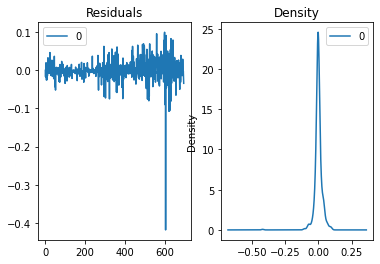

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

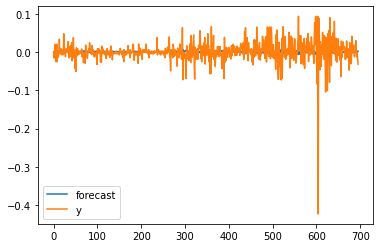

In [ ]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

Như vậy đã train model xong, giờ chúng ta dùng nó để forecast

Test 2 

Auto Arima nhanh gọn lẹ

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)



In [ ]:
df.head(10)

,value
0,88
1,84
2,85
3,85
4,84
5,85
6,83
7,85
8,88
9,89


In [ ]:
model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.05 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

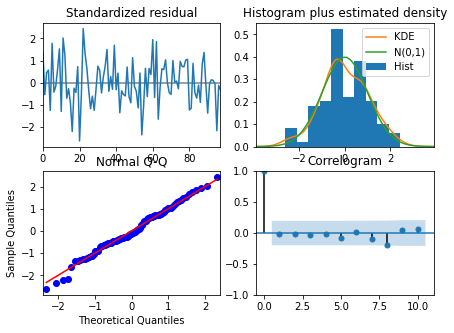

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

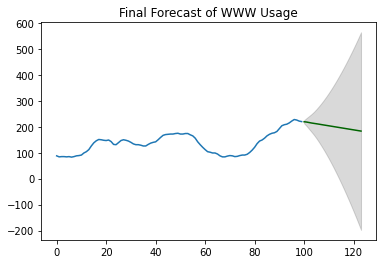

In [ ]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

Test with seasonal data

In [ ]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

In [ ]:
data.head(10)

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
1991-12-01,4.306371
1992-01-01,5.088335
1992-02-01,2.814520
1992-03-01,2.985811


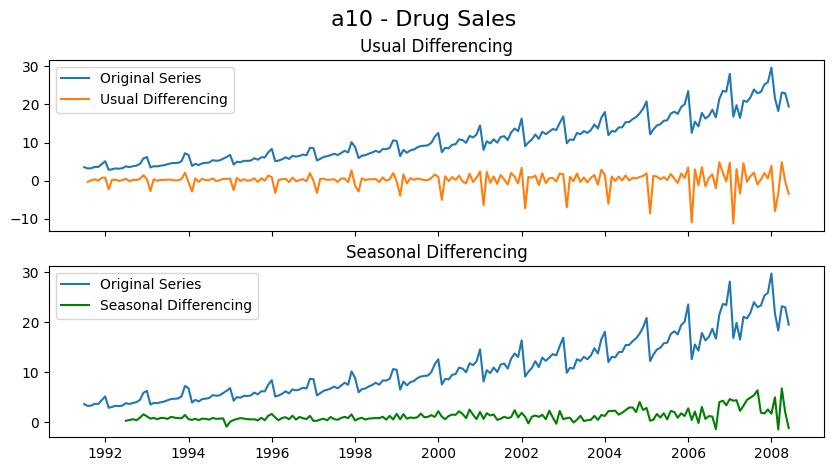

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)
# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)
# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [ ]:
# !pip3 install pyramid-arima
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=1.98 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.72 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.39 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=3.27 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=6.11 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=1.95 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.671, Time=9.39 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.49 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=2.01 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.47 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=4.07 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -253.958
Date:                            Tue, 26 Oct 2021   AIC                            523.916
Time:                                    14:25:31   BIC                            549.976
Sample:                                         0   HQIC                           534.471
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0054      0.009      0.579      0.562      -0.013       0.024
ar.L1          0.9762      0.019     51.973      0.000       0.939       1.013
ma.L1         -0.9076      0.057    -15.899      0.000      -1.020      -0.796
ma.L2          0.2172      0.059      3.674      0.000       0.101       0.333
ar.S.L12       0.8390      0.159      5.268      0.000       0.527       1.151
ma.S.L12      -1.5790      0.180     -8.794      0.000      -1.931      -1.227
ma.S.L24       0.7615      0.112      6.794      0.000       0.542       0.981
sigma2         0.7549      0.067     11.333      0.000       0.624       0.885
===================================================================================
Ljung-Box (Q):                       68.95   Jarque-Bera (JB):               143.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.46   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

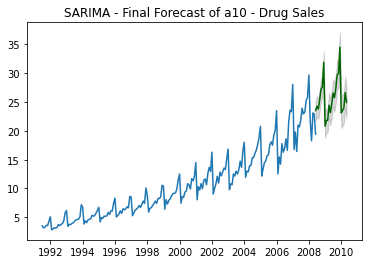

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

Holt Winter Analysis

In [ ]:
# dataframe opertations - pandas
import pandas as pd
# plotting data - matplotlib
from matplotlib import pyplot as plt
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
airline = pd.read_csv('https://raw.githubusercontent.com/maxtran1997gmail/Files/main/international-airline-passengers.csv',header = 0,index_col='Month',names=['Month','Thousands of Passengers'], parse_dates=True)

In [ ]:
airline = airline[0:144]

In [ ]:
airline.head(5)

,Thousands of Passengers
Month,
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0


(144, 1)
         Thousands of Passengers
Month                           
1949-01                    112.0
1949-02                    118.0
1949-03                    132.0
1949-04                    129.0
1949-05                    121.0


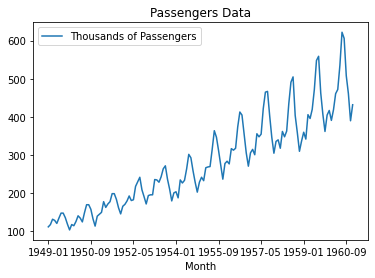

In [ ]:
# finding shape of the dataframe
print(airline.shape)
# having a look at the data
print(airline.head())
# plotting the original data
airline[['Thousands of Passengers']].plot(title='Passengers Data')

In [ ]:
airline.dtypes

Thousands of Passengers    float64
dtype: object

In [ ]:
airline.index

Index(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
       '1949-07', '1949-08', '1949-09', '1949-10',
       ...
       '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
       '1960-09', '1960-10', '1960-11', '1960-12'],
      dtype='object', name='Month', length=144)

In [ ]:
airline.index = pd.to_datetime(airline.index)

In [ ]:
# decompose the time series
decompose_result = seasonal_decompose(airline['Thousands of Passengers'],model='multiplicative')

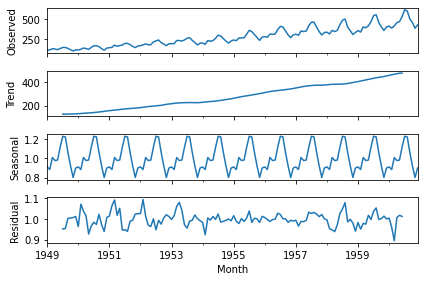

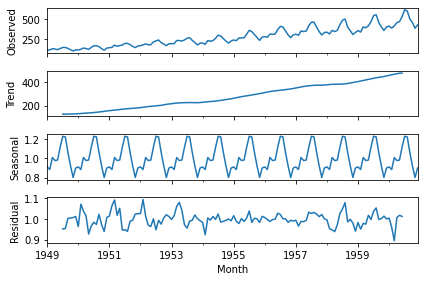

In [ ]:
decompose_result.plot()

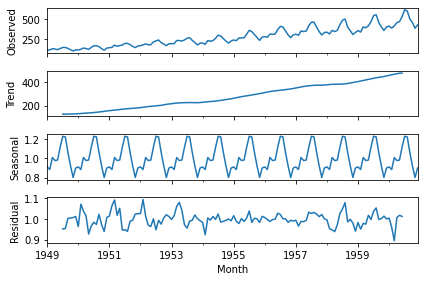

In [ ]:
decompose_result.plot();

In [ ]:
airline.head()

,Thousands of Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [ ]:
airline.dropna(inplace=True)

In [ ]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()

In [ ]:
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()

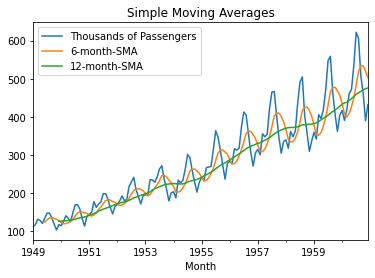

In [ ]:
airline.plot(title='Simple Moving Averages');

In [ ]:
airline.head(12) 

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112.0,NaN,NaN
1949-02-01,118.0,NaN,NaN
1949-03-01,132.0,NaN,NaN
1949-04-01,129.0,NaN,NaN
1949-05-01,121.0,NaN,NaN
1949-06-01,135.0,124.500000,NaN
1949-07-01,148.0,130.500000,NaN
1949-08-01,148.0,135.500000,NaN
1949-09-01,136.0,136.166667,NaN


In [ ]:
airline['ewma12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

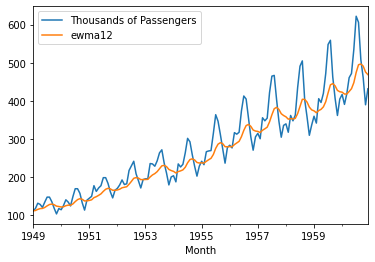

In [ ]:
airline[['Thousands of Passengers','ewma12']].plot();

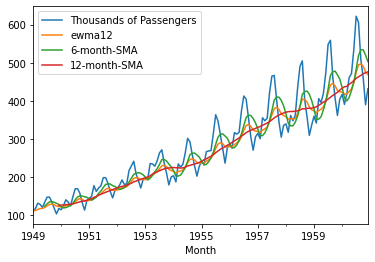

In [ ]:
airline[['Thousands of Passengers','ewma12','6-month-SMA','12-month-SMA']].plot();

In [ ]:
# set the span and the smoothing factor alpha
span = 12
alpha = 2/(span+1)

In [ ]:
airline.columns

Index(['Thousands of Passengers', '6-month-SMA', '12-month-SMA', 'ewma12'], dtype='object')

In [ ]:
# Set the frequency of the date time index as Monthly start as indicated by the data
airline.index.freq = 'MS' 

In [ ]:
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,ewma12
Month,,,,
1949-01-01,112.0,NaN,NaN,112.000000
1949-02-01,118.0,NaN,NaN,112.923077
1949-03-01,132.0,NaN,NaN,115.857988
1949-04-01,129.0,NaN,NaN,117.879836
1949-05-01,121.0,NaN,NaN,118.359861


In [ ]:
airline.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq='MS')

In [ ]:
airline['SES12'] = SimpleExpSmoothing(airline['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

In [ ]:
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,ewma12,SES12
Month,,,,,
1949-01-01,112.0,NaN,NaN,112.000000,112.000000
1949-02-01,118.0,NaN,NaN,112.923077,112.923077
1949-03-01,132.0,NaN,NaN,115.857988,115.857988
1949-04-01,129.0,NaN,NaN,117.879836,117.879836
1949-05-01,121.0,NaN,NaN,118.359861,118.359861


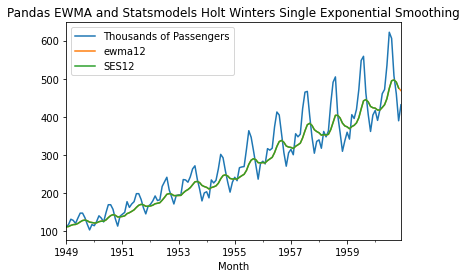

In [ ]:
airline[['Thousands of Passengers','ewma12','SES12']].plot(title='Pandas EWMA and Statsmodels Holt Winters Single Exponential Smoothing');

In [ ]:
airline['DES12'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='add').fit().fittedvalues.shift(-1)

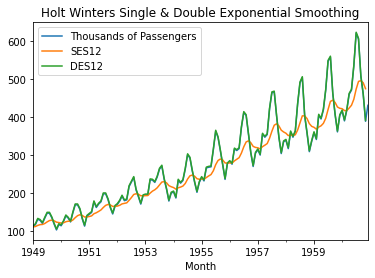

In [ ]:
airline[['Thousands of Passengers','SES12','DES12']].plot(title='Holt Winters Single & Double Exponential Smoothing');

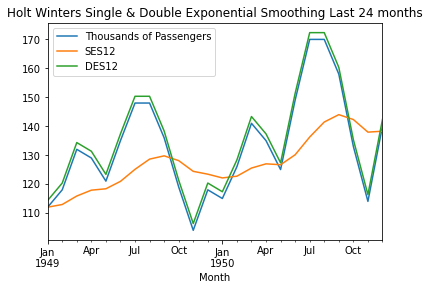

In [ ]:
airline[['Thousands of Passengers','SES12','DES12']].iloc[:24].plot(title='Holt Winters Single & Double Exponential Smoothing Last 24 months').autoscale(axis='x',tight=True);

In [ ]:
airline['DES12_mul'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul').fit().fittedvalues.shift(-1)

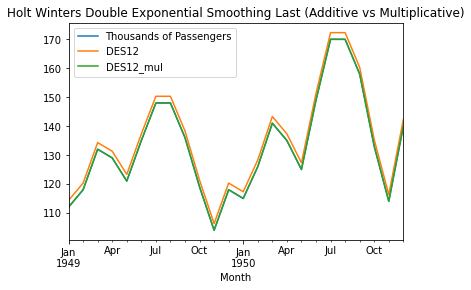

In [ ]:
airline[['Thousands of Passengers','DES12','DES12_mul']].iloc[:24].plot(title='Holt Winters Double Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True);

In [ ]:
airline['TESadd12'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
airline.head()

,Thousands of Passengers,6-month-SMA,12-month-SMA,ewma12,SES12,DES12,DES12_mul,TESadd12
Month,,,,,,,,
1949-01-01,112.0,NaN,NaN,112.000000,112.000000,114.336233,112.049247,113.081288
1949-02-01,118.0,NaN,NaN,112.923077,112.923077,120.336233,118.051885,120.550747
1949-03-01,132.0,NaN,NaN,115.857988,115.857988,134.336233,132.058041,135.527329
1949-04-01,129.0,NaN,NaN,117.879836,117.879836,131.336233,129.056722,133.155064
1949-05-01,121.0,NaN,NaN,118.359861,118.359861,123.336233,121.053204,125.656114


In [ ]:
airline['TESmul12'] = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues

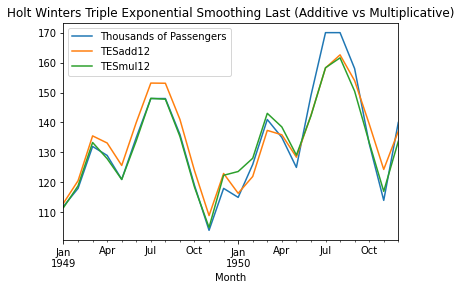

In [ ]:
airline[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(title='Holt Winters Triple Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True);

In [ ]:
airline = pd.read_csv('https://raw.githubusercontent.com/maxtran1997gmail/Files/main/international-airline-passengers.csv',header = 0,index_col='Month',names=['Month','Thousands of Passengers'], parse_dates=True)

In [ ]:
airline = airline[0:144]

In [ ]:
train_airline = airline[:108] 
test_airline = airline[108:] 

In [ ]:
fitted_model = ExponentialSmoothing(train_airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [ ]:
test_predictions = fitted_model.forecast(36).rename('HW Test Forecast')

In [ ]:
test_predictions[:10]

1958-01-01    356.739143
1958-02-01    343.561234
1958-03-01    403.996804
1958-04-01    397.853537
1958-05-01    406.415919
1958-06-01    479.824369
1958-07-01    529.820371
1958-08-01    524.772030
1958-09-01    454.714920
1958-10-01    391.965458
Freq: MS, Name: HW Test Forecast, dtype: float64

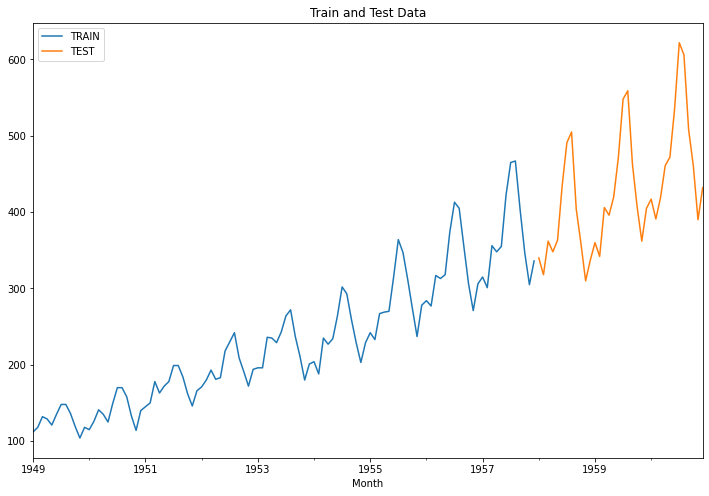

In [ ]:
train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
plt.title('Train and Test Data');

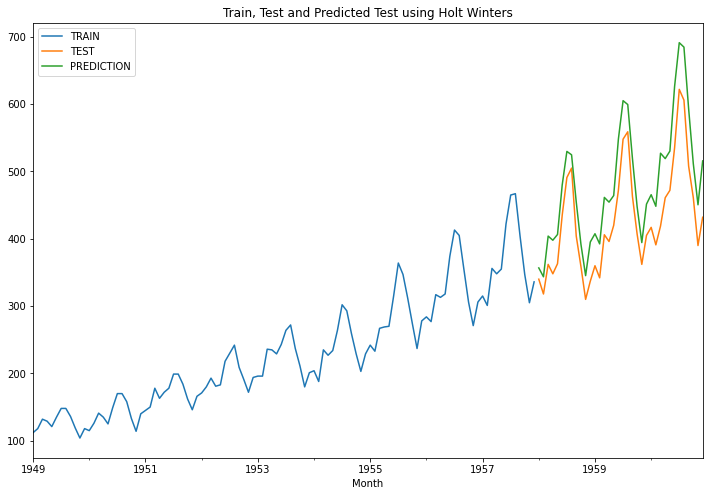

In [ ]:
train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters');

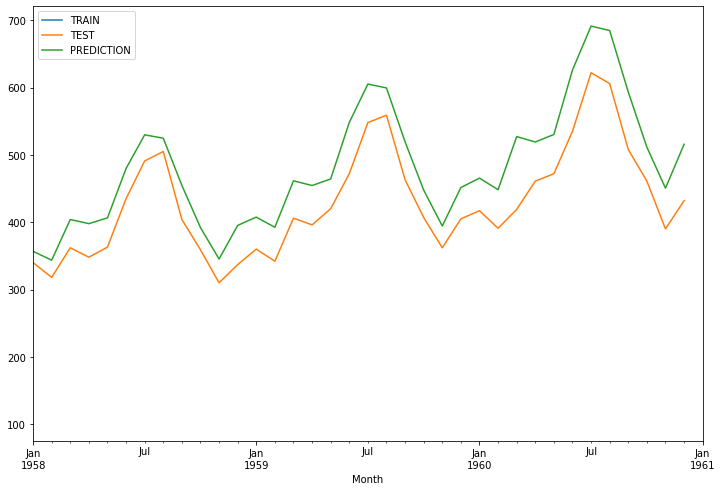

In [ ]:
train_airline['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_airline['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['1958-01-01','1961-01-01']);

In [ ]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [ ]:
print(f'Mean Absolute Error = {mean_absolute_error(test_airline,test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_airline,test_predictions)}')


Mean Absolute Error = 53.16361991340851
Mean Squared Error = 3200.583445912333


In [ ]:
test_airline.describe()

,Thousands of Passengers
count,36.000000
mean,428.500000
std,79.329152
min,310.000000
25%,362.000000
50%,412.000000
75%,472.000000
max,622.000000


In [ ]:
final_model = ExponentialSmoothing(airline['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [ ]:
forecast_predictions = final_model.forecast(steps=36)

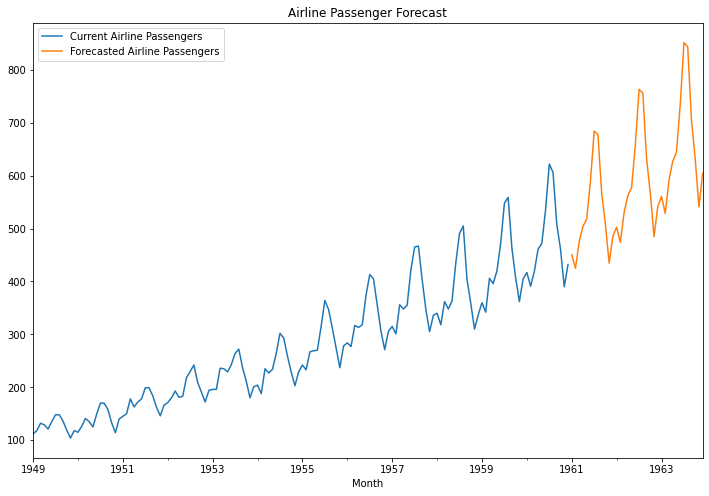

In [ ]:
airline['Thousands of Passengers'].plot(figsize=(12,8),legend=True,label='Current Airline Passengers')
forecast_predictions.plot(legend=True,label='Forecasted Airline Passengers')
plt.title('Airline Passenger Forecast');